In [1]:
# Import relevant libralies
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.pipeline import Pipeline
import pandas as pd
import dask.dataframe as dd
import numpy as np
from scipy.special import expit
import os
import matplotlib.pyplot as plt

# Homework 4
Author: Mao Nishino

## Problem 1
Implement the TISP variable selection method for classification (as described in
pages 12 of the Regularized Loss course notes), with the hard-thresholding penalty,
(which is described in page 11, where you take $η = 0$). Take special care to normal-
ize each column of the $X$ matrix to have zero mean and variance 1, and to use the
same mean and standard deviation that you used for normalizing the train set also for
normalizing the test set.

In [2]:
class TISP():
    """ The TISP algorithm by She (2009)
    Reference:
    https://arxiv.org/pdf/0812.5061.pdf

    Args:
    lambda (float): the regularization hyperparameter
    learn_rate (float): the learning rate
    max_iter (int) : maximum number of iterations
    w_ (numpy.array) : the regression coefficients 
    train_errors(list) : the training errors
    """
    def __init__(
        self,
        lamda: float,
        learn_rate: float,
        max_iter = 100
        ):
        self.lamda = lamda
        self.learn_rate = learn_rate
        self.max_iter = max_iter
        self.w_ = None
        self.train_errors = []   
    
    def _threshold(self, w):
        """ The hard thresholding function
        """
        return np.where(np.abs(w)<self.lamda,
            0,
            w
        )

    def fit(self, X, y):
        w = np.zeros(X.shape[1])
        for i in range(self.max_iter):
            y = y.squeeze()
            Xw = np.matmul(X,w)
            # This is actually -1*gradient
            grad = np.matmul(X.T, y-expit(Xw))
            w = self._threshold(w+self.learn_rate*grad)
            self.w_ = w
            # Calculate train errors
            pred_y = self.predict(X)
            err = 1-accuracy_score(y, pred_y)
            self.train_errors.append(err)
        return self
    
    def predict(self, X):
        Xw = np.matmul(X, self.w_)
        return np.where(
            expit(Xw) > 0.5,
            1,
            0
        )

    def predict_proba(self, X):
        Xw = np.matmul(X, self.w_)
        return expit(Xw)

class AddBias():
    """ Prepends columns of 1s to the dataset
    """
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

class HW4():
    """ A class that achieves everything required for this assignment.
    Attributes:
    lamda_numfeat (numpy.array) : the first column contains the values of lambda, 
                                  and the second column contains the corresponding
                                  number of features 
    misclass_30 (numpy.array) : an array that returns the misclassification error
                                for the i+1th iteration with 30 features
    misclass_all (numpy.array) : first column contains lambda, second #features, 
    third contains train errors, the fourth contains test errors
    train100_pred_proba_y (numpy.array) : an array that contains the predicted value for
                                    the case with 100 features for ROC
    test100_pred_proba_y (numpy.array) : an array that contains the predicted value for
                                    the case with 100 features for ROC
    #f = # features
    All of the arrays are of the format
    [#f=500, #f=300, #f=100, #f=30, #f=10]
    """

    def __init__(self, 
                 train_x : dd.DataFrame,
                 train_y : dd.DataFrame,
                 test_x : dd.DataFrame,
                 test_y : dd.DataFrame,
                 eta = 5,
                 lamda_range = [1000, 1300, 1900, 2190, 2224]) -> None:
        """ Finds all of the attributes.
            Args:
            train_x, train_y : training data
            test_x, test_y : test data
            eta : the learning rate of TISP
            lambda_range : range of lambdas
        """
        num_nonzero = []
        train_errors = []
        test_errors = []
        for lamda in lamda_range:
            pipe = Pipeline([('scaler', StandardScaler()),
                            ('addbias', AddBias()),
                            ('tisp', TISP(lamda=lamda,
                                   learn_rate = eta))])
            pipe.fit(train_x, train_y)
            num_nonzero.append(np.count_nonzero(pipe['tisp'].w_))
            # Calculate train errors
            train_pred_y = pipe.predict(train_x)
            train_error = 1-accuracy_score(train_y, train_pred_y)
            train_errors.append(train_error)
            # Calculate test errors
            test_pred_y = pipe.predict(test_x)
            test_error = 1-accuracy_score(test_y, test_pred_y)
            test_errors.append(test_error)
            
            # if the number of features is apprx 30
            if lamda == lamda_range[3]:
                self.misclass_30 = pipe['tisp'].train_errors
            # If the number of features is apprx 100
            if lamda == lamda_range[1]:
                self.train100_pred_proba_y = pipe.predict_proba(train_x)
                self.test100_pred_proba_y = pipe.predict_proba(test_x)

        self.lamda_numfeat = [list(x) for x in zip(lamda_range, num_nonzero)]
        self.misclass_all = [list(x) for x in zip(lamda_range, num_nonzero, train_errors, test_errors)]
    
    def plot_misclass_30(self):
        plt.figure(figsize = (10,6))
        plt.plot(range(1,101), self.misclass_30)
        plt.title('# Iteration vs Misclassification Error When #Features = 30')
        plt.xlabel('# Iteration')
        plt.ylabel('Misclassification Errors')
        plt.grid(True)
        plt.show()
    
    def plot_misclass_all(self):
        plt.figure(figsize = (10,6))
        num_nonzero  = [item[1] for item in self.misclass_all]
        train_errors = [item[2] for item in self.misclass_all]
        test_errors  = [item[3] for item in self.misclass_all] 
        plt.plot(num_nonzero, train_errors, marker = 'o', label = 'Training Error')
        plt.plot(num_nonzero, test_errors, marker = 'x', label = 'Test Error')        
        plt.title('#Features vs Misclassification Errors')
        plt.xlabel('#Features')
        plt.ylabel('Misclassification Errors')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def report_table(self):
        lamda_range  = [item[0] for item in self.misclass_all]
        num_nonzero  = [item[1] for item in self.misclass_all]
        train_errors = [item[2] for item in self.misclass_all]
        test_errors  = [item[3] for item in self.misclass_all]
        table = {
            'Lambda' : lamda_range,
            '#Features' : num_nonzero,
            'Training Errors' : train_errors,
            'Test Errors' : test_errors
        }
        df = pd.DataFrame(table)
        return df 
    
    def show_roc(self, y, test_y):
        fpr_train, tpr_train, thr = \
            roc_curve(y, self.train100_pred_proba_y)
        fpr_test, tpr_test, thr =  \
            roc_curve(test_y, self.test100_pred_proba_y)

        # Plot ROC
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_train, tpr_train, marker = 'o', label = 'Training ROC')
        plt.plot(fpr_test, tpr_test, marker = 'x', label = 'Test ROC')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.legend()
        plt.title('ROC curves for #features = 100')
        plt.grid(True)
        plt.show()

## Problem (a)
Using the Gisette data, train a TISP classifier on the training set, starting with
w(0) = 0, with 100 iterations. Find appropriate thresholds λ to select approximately 10, 30, 100, 300, 500 features. Plot the train misclassification error vs
iteration number when selecting 30 features. Plot the final train and test misclassification error vs the number of selected features. Report in a table these
misclassification errors on the training and test set, the corresponding numbers
of selected features and the values of λ. Also plot the train and test ROC curves
of the obtained model with 100 features. (3 points)

In [8]:
#Load gisette
path = "./gisette/"
train_x = dd.read_csv(os.path.join(path, 'gisette_train.data'),
                         delim_whitespace = True,
                         header = None,
                         blocksize = None).compute()

train_y = dd.read_csv(os.path.join(path, 'gisette_train.labels'),
                         delim_whitespace=True,
                         header = None,
                         blocksize = None).compute()

test_x = dd.read_csv(os.path.join(path, 'gisette_valid.data'),
                         delim_whitespace=True,
                         header = None, 
                         blocksize = None).compute()

test_y = dd.read_csv(os.path.join(path, 'gisette_valid.labels'),
                         delim_whitespace=True,
                         header = None,
                         blocksize = None).compute()

# Replace -1 with 0 so that it fits the slides
train_y.replace(-1, 0, inplace = True)
test_y.replace(-1, 0, inplace = True)

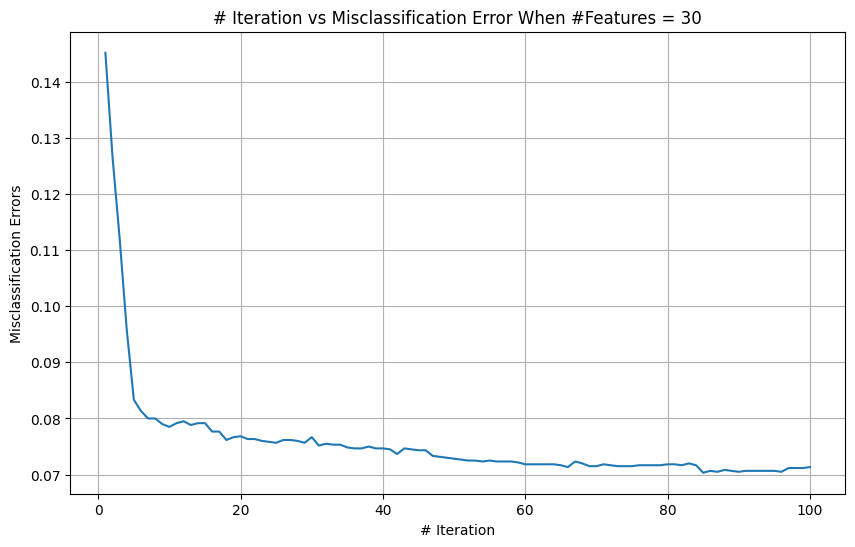

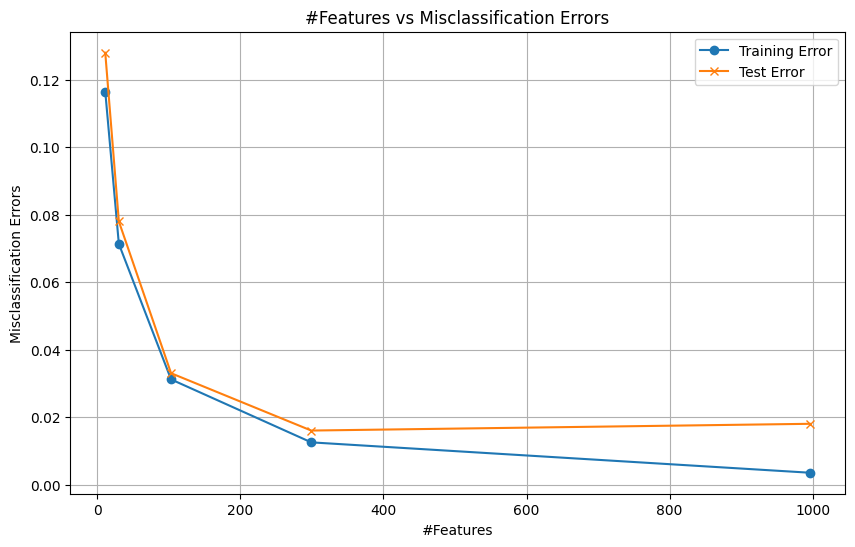

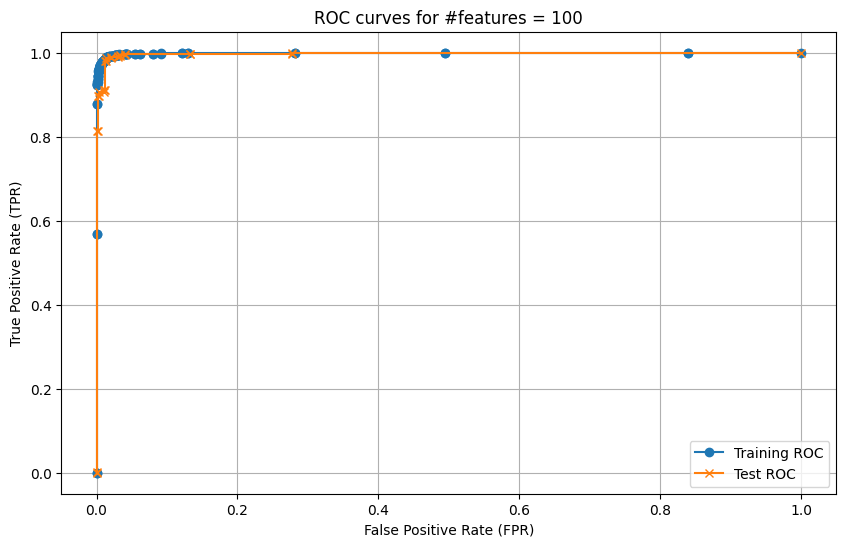

,Lambda,#Features,Training Errors,Test Errors
0,0.0181,996,0.003500,0.018
1,0.0530,299,0.012500,0.016
2,0.0874,103,0.031167,0.033
3,0.1330,30,0.071333,0.078
4,0.1910,11,0.116500,0.128


In [12]:
gs = HW4(train_x, train_y, test_x, test_y,
          eta = 1./train_x.shape[0],
          lamda_range = [0.0181, 0.0530, 0.0874, 0.133, 0.191])
gs.plot_misclass_30()
gs.plot_misclass_all()
df = gs.report_table()
gs.show_roc(train_y, test_y)
df

## Problem (b)
Repeat point a) on the dexter dataset. (3 points)

In [18]:
#Load dexter
path = "./dexter/"

train_x = dd.read_csv(os.path.join(path, 'dexter_train.csv'),
                         header = None,
                         blocksize = None).compute()

train_y = dd.read_csv(os.path.join(path, 'dexter_train.labels'),
                         header = None,
                         blocksize = None).compute()

test_x = dd.read_csv(os.path.join(path, 'dexter_valid.csv'),
                         header = None,
                         blocksize = None).compute()

test_y = dd.read_csv(os.path.join(path, 'dexter_valid.labels'),
                         header = None,
                         blocksize = None).compute()

# Replace -1 with 0 so that it fits the slides
train_y.replace(-1, 0, inplace = True)
test_y.replace(-1, 0, inplace = True)

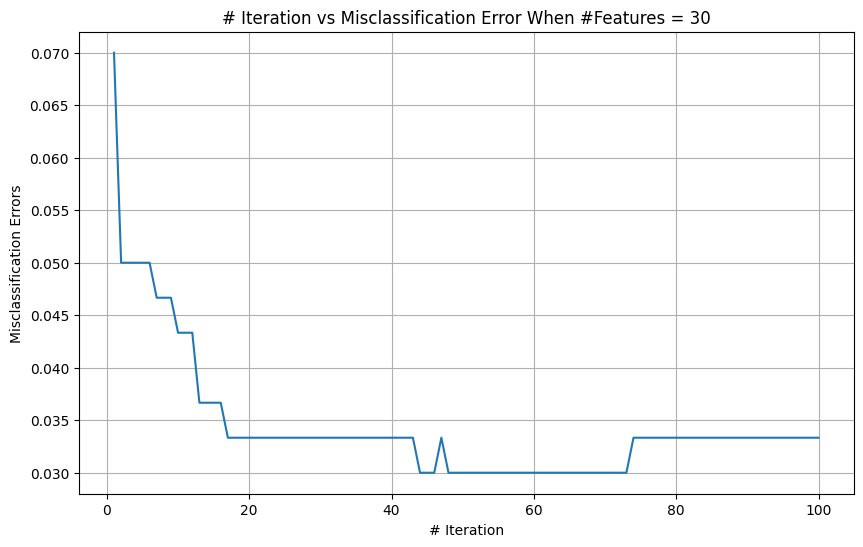

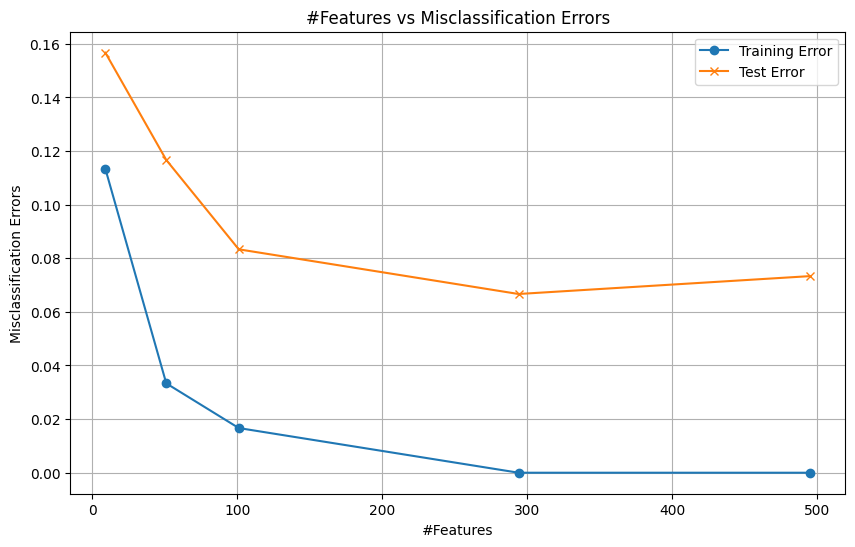

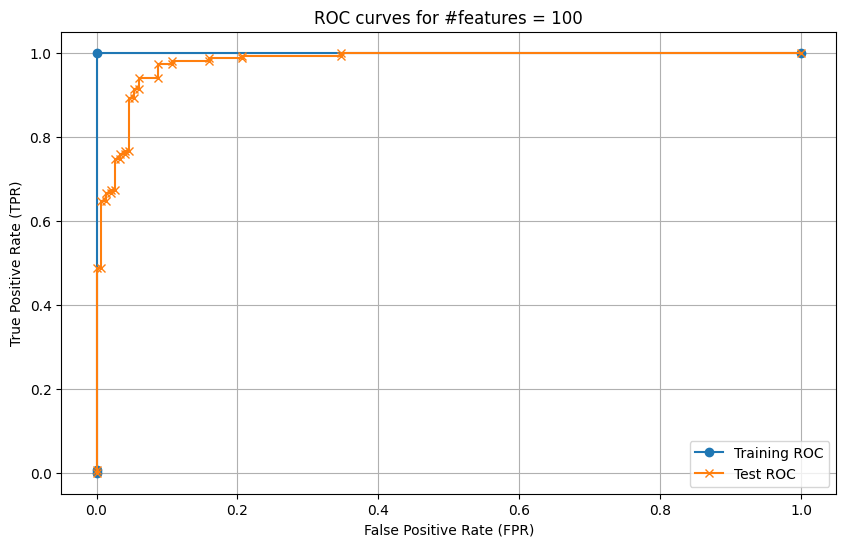

,Lambda,#Features,Training Errors,Test Errors
0,0.0468,495,0.000000,0.073333
1,0.0525,294,0.000000,0.066667
2,0.0710,101,0.016667,0.083333
3,0.0880,51,0.033333,0.116667
4,0.1450,9,0.113333,0.156667


In [29]:
gs = HW4(train_x, train_y, test_x, test_y, eta = 1./train_x.shape[0],
          lamda_range = [0.0468,0.0525,0.071,0.088,0.145])
gs.plot_misclass_30()
gs.plot_misclass_all()
df = gs.report_table()
gs.show_roc(train_y, test_y)
df

## Problem (c)
Repeat point a) on the madelon dataset. (3 points)

In [7]:
# madelon
madelon_x_url = "./MADELON/madelon_train.data"
madelon_y_url = "./MADELON/madelon_train.labels"
madelon_x_test_url = "./MADELON/madelon_valid.data"
madelon_y_test_url = "./MADELON/madelon_valid.labels"
train_x = pd.read_csv(madelon_x_url,
                         header=None,
                         delim_whitespace=True)
train_y = pd.read_csv(madelon_y_url,
                        header=None,
                        delim_whitespace=True)
test_x = pd.read_csv(madelon_x_test_url,
                             header=None,
                             delim_whitespace=True)
test_y = pd.read_csv(madelon_y_test_url,
                             header=None,
                             delim_whitespace=True)

# Replace -1 with 0 so that it fits the slides
train_y.replace(-1, 0, inplace = True)
test_y.replace(-1, 0, inplace = True)

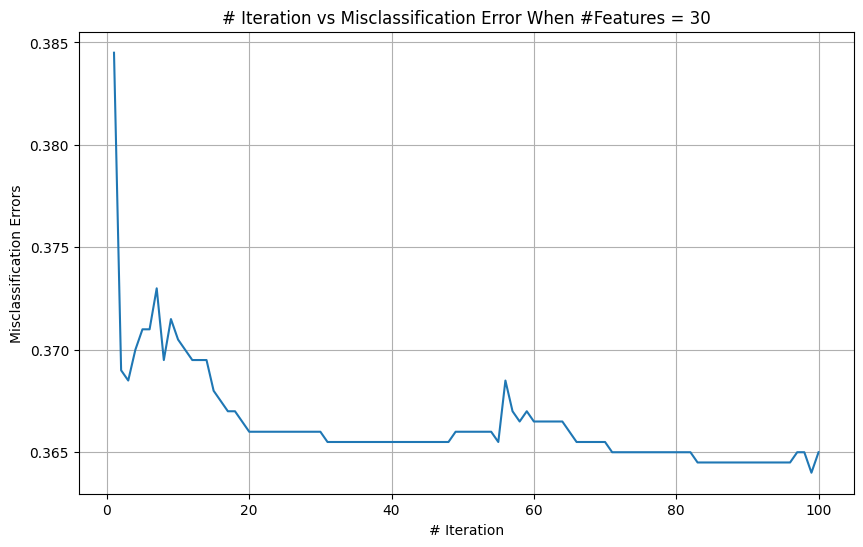

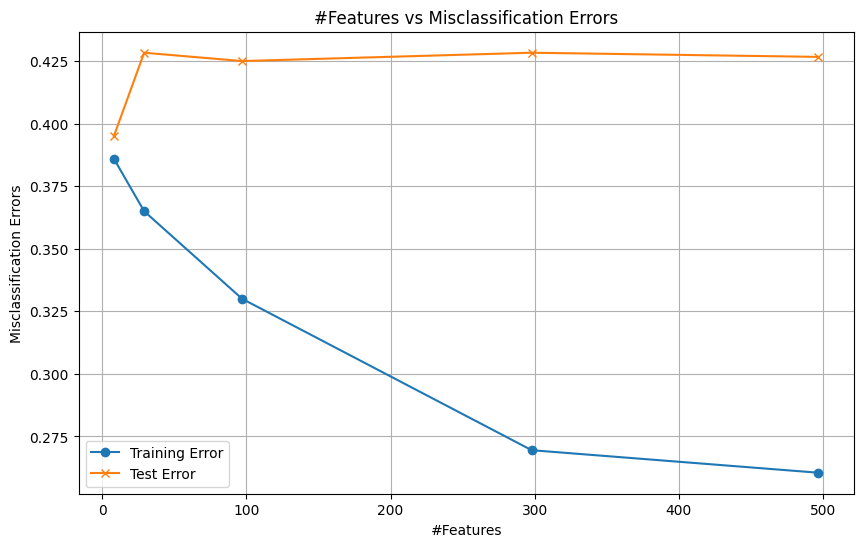

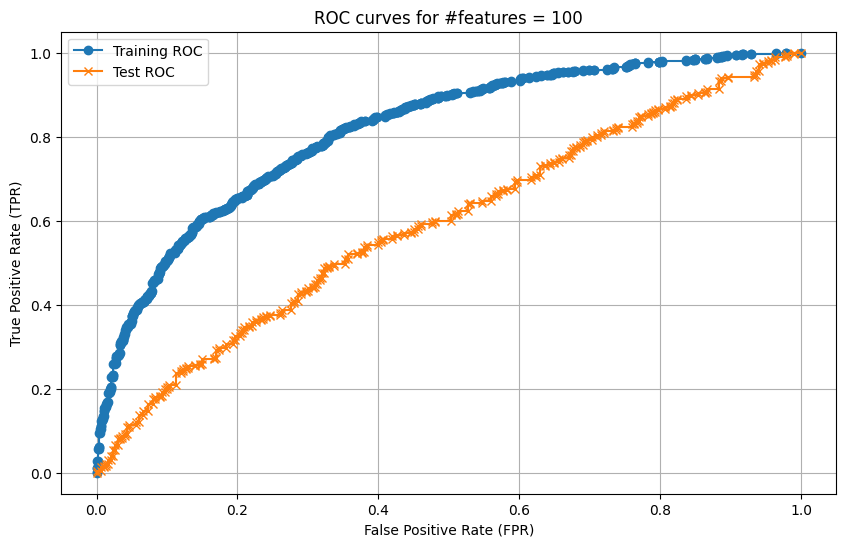

,Lambda,#Features,Training Errors,Test Errors
0,0.00015,497,0.2605,0.426667
1,0.00750,298,0.2695,0.428333
2,0.01750,97,0.3300,0.425000
3,0.02450,29,0.3650,0.428333
4,0.03000,8,0.3860,0.395000


In [17]:
gs = HW4(train_x, train_y, test_x, test_y, eta = 1./train_x.shape[0], 
          lamda_range = [0.00015,0.0075,0.0175,0.0245,0.03])
gs.plot_misclass_30()
gs.plot_misclass_all()
df = gs.report_table()
gs.show_roc(train_y, test_y)

df